# <div align="center"><b> YOLOV11 </b></div>

<div align="right">

<!-- [![Binder](http://mybinder.org/badge.svg)](https://mybinder.org/) -->
[![nbviewer](https://img.shields.io/badge/render-nbviewer-orange?logo=Jupyter)](https://nbviewer.org)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com)

</div>

* * *

<style>
/* Limitar la altura de las celdas de salida en html */
.jp-OutputArea.jp-Cell-outputArea {
    max-height: 500px;
}
</style>

🛻 <em><font color='MediumSeaGreen'>  Instalaciones: </font></em> 🛻

Este notebook utiliza [Poetry](https://python-poetry.org/) para la gestión de dependencias.
Primero instala Poetry siguiendo las instrucciones de su [documentación oficial](https://python-poetry.org/docs/#installation).
Luego ejecuta el siguiente comando para instalar las dependencias necesarias y activar el entorno virtual:

- Bash:
```bash
poetry install
eval $(poetry env activate)
```

- PowerShell:
```powershell
poetry install
Invoke-Expression (poetry env activate)
```

<!-- Descargar archivos adicionales:
!gdown https://drive.google.com/drive/folders/1UBZ8PEbtmiWMGkULu7GAt3VhUpeTy9l7?usp=sharing --folder -->

In [1]:
# Chequear versión de CUDA
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Oct_30_01:18:48_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0


In [2]:
# Chequear más datos sobre la GPU
!nvidia-smi

Thu Jul 10 18:33:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
|  0%   32C    P8              6W /  320W |    1175MiB /  16376MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

✋ <em><font color='DodgerBlue'>Importaciones:</font></em> ✋

In [3]:
# Recarga automática de módulos en Jupyter Notebook
%reload_ext autoreload
%autoreload 2

import sys, json, requests, shutil, os, yaml
from pathlib import Path
from pprint import pprint

import ultralytics
from ultralytics import YOLO, settings
from ultralytics.data.utils import visualize_image_annotations
from ultralytics.engine.results import Results
import torch

import fiftyone as fo

from loguru import logger as LOGGER
from modulo_ia.config import config as CONFIG

import mlflow
import cv2
from PIL import Image

import modulo_ia.dataset as DatasetProcessor
import modulo_ia.features as FeaturesProcessor
import modulo_ia.utils.gpu as GpuUtils
from modulo_ia.modeling.predict import DetectionModelPredictor

import modulo_apps.labeling.procesador_anotaciones_coco_dataset as CocoDatasetUtils
import modulo_apps.s3_comunication.procesador_s3 as ProcesadorS3
import modulo_apps.labeling.visualizador_coco_dataset as VisualizadorCocoDataset
import modulo_apps.labeling.procesador_anotaciones_mongodb as ProcesadorAnotacionesMongoDB
import modulo_apps.labeling.procesador_geojson_kml as ProcesadorGeoJSONKML
from modulo_apps.database_comunication.mongodb_client import mongodb as MONGODB

e:\Documentos\Git Repositories\uba-ceia-proy-final\ceia-proyecto-final\modulo-IA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-10 18:33:35.810 | INFO     | modulo_apps.config:<module>:18 - Directorio de configuración raíz: E:\Documentos\Git Repositories\uba-ceia-proy-final\ceia-proyecto-final\modulo-apps
2025-07-10 18:33:35.812 | INFO     | modulo_apps.config:<module>:22 - Variables de entorno cargadas desde .env.dev.


2025-07-10 18:33:35.821 | INFO     | modulo_ia.config:<module>:19 - Directorio de configuración raíz: E:\Documentos\Git Repositories\uba-ceia-proy-final\ceia-proyecto-final\modulo-IA
2025-07-10 18:33:35.821 | INFO     | modulo_ia.config:<module>:23 - Variables de entorno cargadas desde .env.dev.


🔧 <em><font color='tomato'>Configuraciones:</font></em> 🔧


In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Establece el dispositivo.
LOGGER.remove()
LOGGER.add(sys.stderr, level="INFO")

# Parámetros
SHOULD_PROCESS_DATASET = False  # Descarga el dataset completo
SHOULD_TRAIN = False  # Entrenamiento
BATCH_SIZE = 16  # Tamaño del batch
N_EPOCHS = 10  # Número de épocas
VERBOSE = True  # Muestra época a época la evolución
IMG_SIZE = 640  # Tamaño de la imagen
RANDOM_SEED = CONFIG.seed  # Semilla para la aleatoriedad

RAW_DATA_FOLDER = CONFIG.folders.raw_data_folder
EXTERNAL_DATA_FOLDER = CONFIG.folders.external_data_folder
INTERIM_DATA_FOLDER = CONFIG.folders.interim_data_folder
PROCESSED_DATA_FOLDER = CONFIG.folders.processed_data_folder
DATA_FOLDER = CONFIG.folders.data_folder

DOWNLOAD_PREDICTION_FOLDER = Path("downloads") / "predictions"  # Carpeta para descargar parches de prueba

DATASET_NAME = CONFIG.names.palm_detection_dataset_name
DATASET_VERSION = CONFIG.versions.detection_dataset_version
DATASET_FORMAT = "yolo"
DATASET_IDENTIFIER = f"{DATASET_NAME}_{DATASET_VERSION}"
DATASET_PROCESSED_NAME = f"{DATASET_IDENTIFIER}_{DATASET_FORMAT}"
DATASET_PROCESSED_PATH = PROCESSED_DATA_FOLDER / DATASET_PROCESSED_NAME

MODEL_NAME = "yolo11n"
EXPERIMENT_NAME = f"{DATASET_IDENTIFIER}_{MODEL_NAME.replace('/', '_')}_{IMG_SIZE}"  # Nombre del experimento
MODEL_FOLDER = CONFIG.folders.models_folder / EXPERIMENT_NAME
MODEL_CHECKPOINT = f"{MODEL_NAME}.pt"

# Configuraciones de MLflow
MLFLOW_URL = CONFIG.mlflow.tracking_uri
os.environ["MLFLOW_TRACKING_URI"] = MLFLOW_URL  # Configura la URI de seguimiento de MLflow.
os.environ["MLFLOW_EXPERIMENT_NAME"] = EXPERIMENT_NAME  # Configura el nombre del experimento de MLflow.
os.environ["MLFLOW_TAGS"] = (
    '{"model_family": "palm_detection", "model_version": "v1.0"}'  # Configura las etiquetas del experimento de MLflow.
)
settings.update({"mlflow": True})  # Habilita el uso de MLflow en ultralytics

ultralytics.checks()  # Verifica la instalación de ultralytics
LOGGER.info(f"Dispositivo actual: {DEVICE}")

Ultralytics 8.3.161  Python-3.13.3 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
Setup complete  (20 CPUs, 127.9 GB RAM, 1063.2/1862.9 GB disk)


2025-07-10 18:33:39.694 | INFO     | __main__:<module>:44 - Dispositivo actual: cuda


<div align="center">✨Datos del proyecto:✨</div>

<p></p>

<div align="center">

| Subtitulo       | YoloV11 - Detección de palmeras                                                                                                                |
| --------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Descrpción**  | Notebook de detección de palmeras utilizando YoloV11                                                                                                          |
| **Integrantes** | Bruno Masoller (brunomaso1@gmail.com)                                                                                                  |

</div>

# Chequeo de conexiones

In [5]:
# Chequeo de conexión a MLflow
LOGGER.info(f"Conectando a MLflow en {MLFLOW_URL}...")
try:
    response = requests.get(MLFLOW_URL)
    response.raise_for_status()  # Verifica si la solicitud fue exitosa.
    LOGGER.success("Conexión a MLflow establecida correctamente.")
    
except Exception as e:
    LOGGER.error(f"Error al conectar con MLflow. Tienes levantado el servidor de MLflow?")
    raise SystemExit(f"Error al conectar con MLflow: {e}")

# Chequeo de conexión a MinIO
LOGGER.info("Chequeando conexión a MinIO...")
ProcesadorS3.check_connection()

# Chequeo de conexión a MongoDB
LOGGER.info("Chequeando conexión a MongoDB...")
MONGODB.command("ping")  # Verifica la conexión a MongoDB
LOGGER.success("Conexión a MongoDB verificada correctamente.")

2025-07-10 18:33:39.745 | INFO     | __main__:<module>:2 - Conectando a MLflow en http://picudo-rojo-desarrollo.org:5000...
2025-07-10 18:33:39.752 | SUCCESS  | __main__:<module>:6 - Conexión a MLflow establecida correctamente.
2025-07-10 18:33:39.752 | INFO     | __main__:<module>:13 - Chequeando conexión a MinIO...
2025-07-10 18:33:39.758 | SUCCESS  | modulo_apps.s3_comunication.procesador_s3:check_connection:29 - Conexión exitosa a MinIO y acceso al bucket 'picudo-rojo-bucket' verificado.
2025-07-10 18:33:39.759 | INFO     | __main__:<module>:17 - Chequeando conexión a MongoDB...
2025-07-10 18:33:39.768 | SUCCESS  | __main__:<module>:19 - Conexión a MongoDB verificada correctamente.


## Descarga del dataset

In [6]:
if SHOULD_PROCESS_DATASET:
    # Descarga el dataset completo
    LOGGER.info("Descargando el dataset completo...")
    DatasetProcessor.download_full_raw_dataset()

## Analisis de datos

### Convertir todas las clases a una sola

In [7]:
json_folder = RAW_DATA_FOLDER / f"{DATASET_NAME}_{DATASET_VERSION}"
coco_anotations = CocoDatasetUtils.load_annotations_from_path(
    json_folder / "labels.json"
)
coco_annotations_one_class = CocoDatasetUtils.parse_class_annotations_to(coco_anotations, "palmera")

with open(json_folder / "labels.json", "w") as f:
    json.dump(coco_annotations_one_class, f, indent=4)
    LOGGER.info(f"Se guardó el archivo de etiquetas en {json_folder / 'labels.json'}")

2025-07-10 18:33:39.929 | INFO     | __main__:<module>:9 - Se guardó el archivo de etiquetas en E:\Documentos\Git Repositories\uba-ceia-proy-final\ceia-proyecto-final\modulo-IA\data\raw\coco_palm_detection_dataset_v1.0\labels.json


### Convertir dataset a formato YOLO
<small><em>https://docs.ultralytics.com/reference/cfg/__init__/</em></small>

In [8]:
if SHOULD_PROCESS_DATASET:
    LOGGER.info("Convirtiendo el dataset a formato de modelo...")
    DatasetProcessor.convert_dataset_to_model_format()

Ejemplo con views splits:

```python
for split in splits:
    split_view = dataset_or_view.match_tags(split)
    split_view.export(
        export_dir=export_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field=label_field,
        split=split,
        classes=classes,
    )
```

### Recortar el dataset en imágenes pequeñas

In [9]:
if SHOULD_PROCESS_DATASET:
    LOGGER.info("Cortando el dataset para entrenamiento...")
    # Corta el dataset para entrenamiento
    FeaturesProcessor.crop_dataset()

### Balancear el dataset

In [10]:
if SHOULD_PROCESS_DATASET:
    LOGGER.info("Balanceando el dataset...")
    # Balancea el dataset
    FeaturesProcessor.balance_dataset()

### Split del dataset

In [11]:
if SHOULD_PROCESS_DATASET:
    LOGGER.info("Split del dataset...")
    # Divide el dataset en train, val y test
    DatasetProcessor.split_dataset()

### Metricas del dataset

In [12]:
dataset_metrics = DatasetProcessor.get_dataset_metrics()
LOGGER.info("Métricas del dataset:")
LOGGER.info(dataset_metrics)

You are running the oldest supported major version of MongoDB. Please refer to https://deprecation.voxel51.com for deprecation notices. You can suppress this exception by setting your `database_validation` config parameter to `False`. See https://docs.voxel51.com/user_guide/config.html#configuring-a-mongodb-connection for more information
 100% |███████████████| 3630/3630 [2.5s elapsed, 0s remaining, 1.4K samples/s]      
 100% |█████████████████| 454/454 [271.8ms elapsed, 0s remaining, 1.7K samples/s]     
 100% |█████████████████| 454/454 [262.3ms elapsed, 0s remaining, 1.7K samples/s]     


2025-07-10 18:33:48.080 | INFO     | __main__:<module>:2 - Métricas del dataset:
2025-07-10 18:33:48.080 | INFO     | __main__:<module>:3 - {'train_count': 3630, 'val_count': 454, 'test_count': 454, 'total_count': 4538}


### Visualización

#### Observamos el dataset

> 📝 <em><font color='Gray'>Nota:</font></em> Si hay problema de versiones con `FiftyOne`, borrar la base de datos del mismo que se encuentra en: `C:\Users\<usuario>\.fiftyone\`</em>

In [13]:
if SHOULD_PROCESS_DATASET:
    DatasetProcessor.copy_dataset_to_quality(DATASET_PROCESSED_PATH, DATASET_PROCESSED_NAME)

Accedemos a la visualización: <a>http://picudo-rojo-desarrollo.org:5151</a>

#### Observamos algunas imágenes

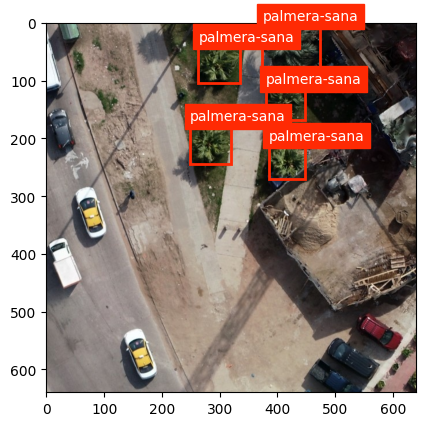

In [14]:
image_name = "8deOctubreyCentenario-EspLibreLarranaga_20190828_dji_pc_5cm_crop_31"
image_path = DATASET_PROCESSED_PATH / "images" / "train" / f"{image_name}.jpg"
txt_path = DATASET_PROCESSED_PATH / "labels" / "train" / f"{image_name}.txt"

categories = CONFIG.coco_dataset.to_dict()['categories']
category_map = {cat["id"]: cat["name"] for cat in categories}

visualize_image_annotations(image_path, txt_path, category_map)

## Entrenamiento del modelo

Creamos el modelo de detección de objetos YOLOv11:

<small><em>https://docs.ultralytics.com/modes/train/#train-settings</em></small>

In [15]:
if SHOULD_TRAIN:
    model = YOLO(MODEL_CHECKPOINT)
else:
    model = YOLO(Path(EXPERIMENT_NAME) / "train" / "weights" / "best.pt")

Imprimimos el modelo:

In [16]:
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

Mostramos información del modelo:

> 📝 <em><font color='Gray'>Nota:</font></em> $\text{Max batch size} = \frac{\text{Available GPU memory (bytes)}}{4 \times (\text{Size of tensors} + \text{Trainable parameters})}$


Max batch size = available GPU memory bytes / 4 / (size of tensors + trainable parameters)

In [17]:
print(f"Información básica del modelo:")
model.info()

Información básica del modelo:
YOLO11n summary: 181 layers, 2,590,035 parameters, 0 gradients, 6.4 GFLOPs


(181, 2590035, 0, 6.4406016)

Entrenamos el modelo:

In [18]:
if SHOULD_TRAIN:
    with mlflow.start_run():
        mlflow.set_experiment(EXPERIMENT_NAME)  # Establece el experimento de MLflow
        mlflow.log_param("dataset_name", DATASET_NAME)  # Registra el nombre del dataset
        mlflow.log_param("dataset_version", DATASET_VERSION)  # Registra la versión del dataset
        mlflow.log_param("dataset_format", DATASET_FORMAT)  # Registra el formato del dataset
        mlflow.log_param("dataset_processed_name", DATASET_PROCESSED_NAME)  # Registra el nombre del dataset procesado
        mlflow.log_param("dataset_metrics", json.dumps(dataset_metrics))  # Registra las métricas del dataset como JSON
        mlflow.log_param("transforms", "crop, balance")  # Registra las transformaciones aplicadas al dataset
        mlflow.log_param("model_name", MODEL_NAME)  # Registra el nombre del modelo
        mlflow.log_param("img_size", IMG_SIZE)  # Registra el tamaño de la imagen
        
        history = model.train(
            data=str(DATASET_PROCESSED_PATH / "dataset.yaml"),
            epochs=N_EPOCHS,
            batch=BATCH_SIZE,
            device=0,
            imgsz=IMG_SIZE,
            project=EXPERIMENT_NAME,
            seed=CONFIG.seed,
            exist_ok=True,
            save_period=1,
            patience=50,
            # cache=True,
            # plots=True,
        )

## Validación del modelo

Cargamos el mejor modelo:

In [19]:
print(f"Nombre del proyecto: {EXPERIMENT_NAME}")
best_model_path = Path(EXPERIMENT_NAME) / "train" / "weights" / "best.pt"

if not best_model_path.exists():
    LOGGER.error(f"El modelo {best_model_path} no existe")
    sys.exit(1)
best_model = YOLO(best_model_path)

Nombre del proyecto: coco_palm_detection_dataset_v1.0_yolo11n_640


Limpiamos la GPU:

In [20]:
GpuUtils.clean_gpu_usage()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 | 11% |  7% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  9% |  7% |


Validamos el modelo:

In [21]:
metrics = best_model.val(
    project=EXPERIMENT_NAME,
    data=str(DATASET_PROCESSED_PATH / "dataset.yaml"),
    exist_ok=True
)

Ultralytics 8.3.161  Python-3.13.3 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16376MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1719.8421.4 MB/s, size: 198.0 KB)


val: Scanning E:\Documentos\Git Repositories\uba-ceia-proy-final\ceia-proyecto-final\modulo-IA\data\processed\coco_palm_detection_dataset_v1.0_yolo\labels\val.cache... 454 images, 235 backgrounds, 0 corrupt: 100%|██████████| 454/454 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:02<00:00, 13.36it/s]


                   all        454        426      0.838      0.718      0.771      0.532
Speed: 0.3ms preprocess, 1.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to coco_palm_detection_dataset_v1.0_yolo11n_640\val


Imprimimos el reporte de validación:

In [22]:
metrics.summary()

[{'Class': 'palmera',
  'Images': np.int64(219),
  'Instances': np.int64(426),
  'Box-P': np.float64(0.83839),
  'Box-R': np.float64(0.71831),
  'Box-F1': np.float64(0.77372),
  'mAP50': np.float64(0.77072),
  'mAP50-95': np.float64(0.53208)}]

## Predicción

Cargamos el modelo:

In [23]:
print(f"Nombre del proyecto: {EXPERIMENT_NAME}")
best_model_path = Path(EXPERIMENT_NAME) / "train" / "weights" / "best.pt"

if not best_model_path.exists():
    LOGGER.error(f"El modelo {best_model_path} no existe")
    sys.exit(1)

best_model = YOLO(best_model_path)

Nombre del proyecto: coco_palm_detection_dataset_v1.0_yolo11n_640


Descargamos la imagen de prueba:

In [24]:
image_name = "8deOctubreyCentenario-EspLibreLarranaga_20190828_dji_pc_5cm"
Path(DOWNLOAD_PREDICTION_FOLDER).mkdir(parents=True, exist_ok=True)
image_file_path = DOWNLOAD_PREDICTION_FOLDER / f"{image_name}.jpg"
ProcesadorS3.download_images_from_minio([image_name], DOWNLOAD_PREDICTION_FOLDER)
LOGGER.debug(f"Se descargó la imagen {image_file_path} desde MinIO")

Descargando imágenes: 100%|██████████| 1/1 [00:00<00:00, 14.67MB/s]


### Predicción normal

Realizamos la predicción normal:

In [25]:
result = best_model.predict(image_file_path)[0]


image 1/1 e:\Documentos\Git Repositories\uba-ceia-proy-final\ceia-proyecto-final\modulo-IA\notebooks\deteccion_palmeras\yolov11\downloads\predictions\8deOctubreyCentenario-EspLibreLarranaga_20190828_dji_pc_5cm.jpg: 640x544 (no detections), 38.5ms
Speed: 2.9ms preprocess, 38.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


Obtenemos los resultados:

In [26]:
xywh = result.boxes.xywh  # center-x, center-y, width, height
xywhn = result.boxes.xywhn  # normalized
xyxy = result.boxes.xyxy  # top-left-x, top-left-y, bottom-right-x, bottom-right-y
xyxyn = result.boxes.xyxyn  # normalized
names = [result.names[cls.item()] for cls in result.boxes.cls.int()]  # class name of each box
confs = result.boxes.conf  # confidence score of each box

print(f"Resultados para la imagen: {image_name}")
print(f"Cantidad de detecciones: {len(names)}")
if len(names) == 0:
    print("No se detectaron objetos.")
else:
    for i, (name, conf, box) in enumerate(zip(names, confs, xyxy)):
        print(f"Detección {i+1}: Clase={name}, Confianza={conf.item():.2f}, Caja={box.tolist()}")

Resultados para la imagen: 8deOctubreyCentenario-EspLibreLarranaga_20190828_dji_pc_5cm
Cantidad de detecciones: 0
No se detectaron objetos.


Filtramos los resultados según la confianza:

In [27]:
confidence_threshold = 0.50  # Ajusta según necesidad

# Filtrar los índices según el umbral
filtered_indices = [i for i, conf in enumerate(result.boxes.conf) if conf.item() >= confidence_threshold]

# Filtrar las cajas y otros atributos
filtered_boxes = result.boxes[filtered_indices]

# Crear un nuevo objeto Results con las mismas propiedades pero solo con las detecciones filtradas
results_filtered = Results(
    orig_img=result.orig_img,
    path=result.path,
    names=result.names,
)
results_filtered.boxes = filtered_boxes
results_filtered.orig_shape = result.orig_shape
results_filtered.speed = result.speed
results_filtered.save_dir = result.save_dir

Mostramos los resultados filtrados:

In [28]:
xywh = results_filtered.boxes.xywh  # center-x, center-y, width, height
xywhn = results_filtered.boxes.xywhn  # normalized
xyxy = results_filtered.boxes.xyxy  # top-left-x, top-left-y, bottom-right-x, bottom-right-y
xyxyn = results_filtered.boxes.xyxyn  # normalized
names = [results_filtered.names[cls.item()] for cls in results_filtered.boxes.cls.int()]  # class name of each box
confs = results_filtered.boxes.conf  # confidence score of each box

print(f"Resultados para la imagen: {image_name}")
print(f"Cantidad de detecciones: {len(names)}")
if len(names) == 0:
    print("No se detectaron objetos.")
else:
    for i, (name, conf, box) in enumerate(zip(names, confs, xyxy)):
        print(f"Detección {i+1}: Clase={name}, Confianza={conf.item():.2f}, Caja={box.tolist()}")

Resultados para la imagen: 8deOctubreyCentenario-EspLibreLarranaga_20190828_dji_pc_5cm
Cantidad de detecciones: 0
No se detectaron objetos.


### Predicción SAHI

In [29]:
model_predictor = DetectionModelPredictor(model=best_model, target_img_size_wh=[IMG_SIZE, IMG_SIZE])
predictions = model_predictor.predict(image_file_path)
result_df = predictions.as_pandas()


0: 640x640 (no detections), 41.6ms
Speed: 1.8ms preprocess, 41.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 5.8ms
Speed: 1.5ms preprocess, 5.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 5.9ms
Speed: 1.6ms preprocess, 5.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.0m

Mostramos la imagen sin filtrar los resultados:

In [30]:
annotated_image = predictions.get_annotated_image(cv2.imread(str(image_file_path)))
annotated_image_path = DOWNLOAD_PREDICTION_FOLDER / f"annotated_{image_file_path.name}_witout_filter.jpg"
cv2.imwrite(str(annotated_image_path), annotated_image)

Image.open(annotated_image_path).show()

Filtramos los resultados según la confianza:

In [31]:
predictions = predictions.filter_by_confidence()

Mostramos la imagen filtrada:

In [32]:
annotated_image = predictions.get_annotated_image(cv2.imread(str(image_file_path)))
annotated_image_path = DOWNLOAD_PREDICTION_FOLDER / f"annotated_{image_file_path.name}"
cv2.imwrite(str(annotated_image_path), annotated_image)

Image.open(annotated_image_path).show()

Convertimos los resultados a anotaciones:

In [33]:
coco_annotations = predictions.as_coco_annotations(image_name, should_download=True)
print("Anotaciones COCO:")
pprint(coco_annotations)

2025-07-10 18:34:10.305 | SUCCESS  | modulo_apps.labeling.procesador_anotaciones_coco_dataset:create_coco_annotations_from_detections:281 - Anotaciones COCO guardadas en downloads\coco_annotations\coco_annotations.json


Anotaciones COCO:
{'annotations': [{'area': 9548.891891889274,
                  'attributes': {'occluded': False, 'rotation': 0.0},
                  'bbox': [2916.0087890625,
                           1631.144287109375,
                           102.05377197265625,
                           93.5672607421875],
                  'category_id': 0,
                  'confidence': 0.7916043387427668,
                  'id': 1,
                  'image_id': 1,
                  'iscrowd': 0},
                 {'area': 10490.557388262823,
                  'attributes': {'occluded': False, 'rotation': 0.0},
                  'bbox': [3014.762451171875,
                           1745.8926239013672,
                           101.6534423828125,
                           103.19923400878906],
                  'category_id': 0,
                  'confidence': 0.7499715089797974,
                  'id': 2,
                  'image_id': 1,
                  'iscrowd': 0},
                 {'

Visualizamos los resultados:

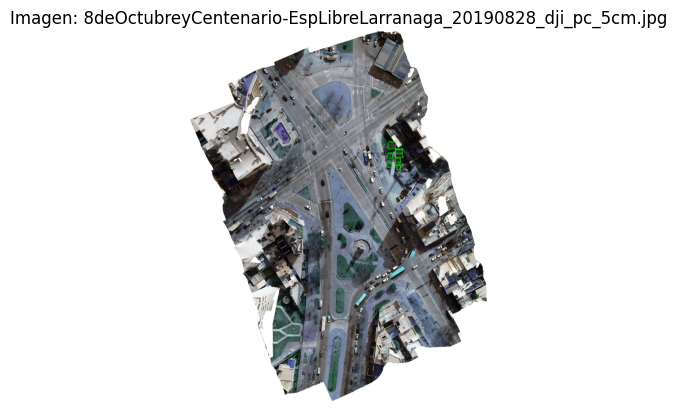

In [34]:
VisualizadorCocoDataset.show_anotated_image(image_path=image_file_path, coco_annotations=coco_annotations)

Mostramos los puntos:

In [35]:
predictions.as_pandas()

,x1,y1,x2,y2,confidence,class_id,class_name
0,2916.008789,1631.144287,3018.062561,1724.711548,0.791604,0,palmera
1,3014.762451,1745.892624,3116.415894,1849.091858,0.749972,0,palmera
2,2890.325867,1935.445801,2958.991394,2002.516708,0.570787,0,palmera
3,3020.499023,1868.888214,3086.650391,1930.023468,0.593049,0,palmera
4,3025.948059,1967.943359,3090.182922,2034.908745,0.549316,0,palmera
5,2902.573975,1796.221893,2970.836761,1865.079712,0.538673,0,palmera
6,3012.096771,1742.940552,3117.396027,1791.318848,0.521446,0,palmera


#### Generar KML

In [36]:
jgw_data = ProcesadorAnotacionesMongoDB.load_jgw_file_from_mongodb(image_name=image_name, should_download=True)
pprint(jgw_data)

2025-07-10 18:34:11.259 | SUCCESS  | modulo_apps.labeling.procesador_anotaciones_mongodb:load_jgw_file_from_mongodb:676 - Archivo JGW guardado en downloads\jgw\jgw_data.json.


{'x_origin': 577344.7165226148,
 'x_pixel_size': 0.05,
 'x_rotation': 0.0,
 'y_origin': 6139798.10234485,
 'y_pixel_size': -0.05,
 'y_rotation': 0.0}


In [37]:
gdf = ProcesadorGeoJSONKML.create_geojson_from_annotations(image_name, coco_annotations, jgw_data, should_download=True)
gdf.head()

2025-07-10 18:34:11.357 | INFO     | modulo_apps.labeling.procesador_geojson_kml:create_geojson_from_annotations:216 - GeoJSON guardado en downloads\geojson\annotations.geojson


,category,annotation_id,bbox_x,bbox_y,bbox_width,bbox_height,global_tl_x,global_tl_y,global_br_x,global_br_y,geometry
0,palmera-sana,1,2916.008789,1631.144287,102.053772,93.567261,577490.516962,6.139717e+06,577495.619651,6.139712e+06,POINT (577493.068 6139714.206)
1,palmera-sana,2,3014.762451,1745.892624,101.653442,103.199234,577495.454645,6.139711e+06,577500.537317,6.139706e+06,POINT (577497.996 6139708.228)
2,palmera-sana,3,2890.325867,1935.445801,68.665527,67.070908,577489.232816,6.139701e+06,577492.666092,6.139698e+06,POINT (577490.949 6139699.653)
3,palmera-sana,4,3020.499023,1868.888214,66.151367,61.135254,577495.741474,6.139705e+06,577499.049042,6.139702e+06,POINT (577497.395 6139703.13)
4,palmera-sana,5,3025.948059,1967.943359,64.234863,66.965385,577496.013926,6.139700e+06,577499.225669,6.139696e+06,POINT (577497.62 6139698.031)


In [38]:
kml = ProcesadorGeoJSONKML.generate_kml_from_geojson(gdf, should_download=True)

2025-07-10 18:34:11.425 | INFO     | modulo_apps.labeling.procesador_geojson_kml:generate_kml_from_geojson:313 - Archivo KML guardado en downloads\kmls\palmeras.kml


In [45]:
# Test
kml_text = kml.to_string()
gdf_test = ProcesadorGeoJSONKML.convert_kml_to_geojson(kml_text)

2025-07-10 18:38:24.334 | SUCCESS  | modulo_apps.labeling.procesador_geojson_kml:convert_kml_to_geojson:101 - Conversión exitosa.
